Initial weight norm (default): 6.429586
Initial weight norm (zero):    0.000000
Final accuracy (default init): 99.90%
Final accuracy (zero init):    50.00%
Final accuracy (default init): 99.90%
Final accuracy (zero init):    50.00%


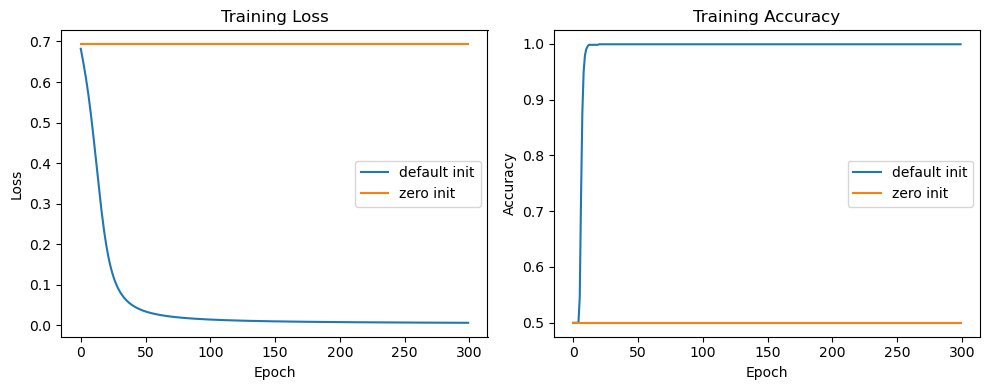


Sample final weight slices (first Linear weight matrix):
default: tensor([[ 0.6955,  0.7886],
        [-0.1889,  0.6320]])
zero   : tensor([[0., 0.],
        [0., 0.]])

=== Additional experiments: compare initializations ===
default         final acc: 99.80% loss: 0.0106
default         final acc: 99.80% loss: 0.0106
zero            final acc: 50.00% loss: 0.6931
zero            final acc: 50.00% loss: 0.6931
xavier          final acc: 99.80% loss: 0.0091
xavier          final acc: 99.80% loss: 0.0091
kaiming         final acc: 99.80% loss: 0.0084
kaiming         final acc: 99.80% loss: 0.0084
bias_zero_only  final acc: 99.70% loss: 0.0099
bias_zero_only  final acc: 99.70% loss: 0.0099


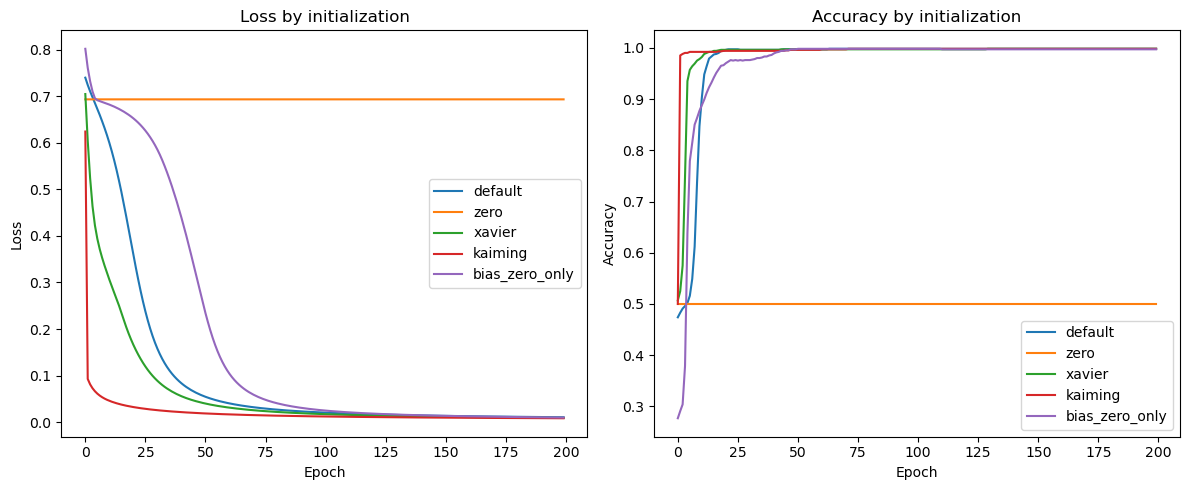

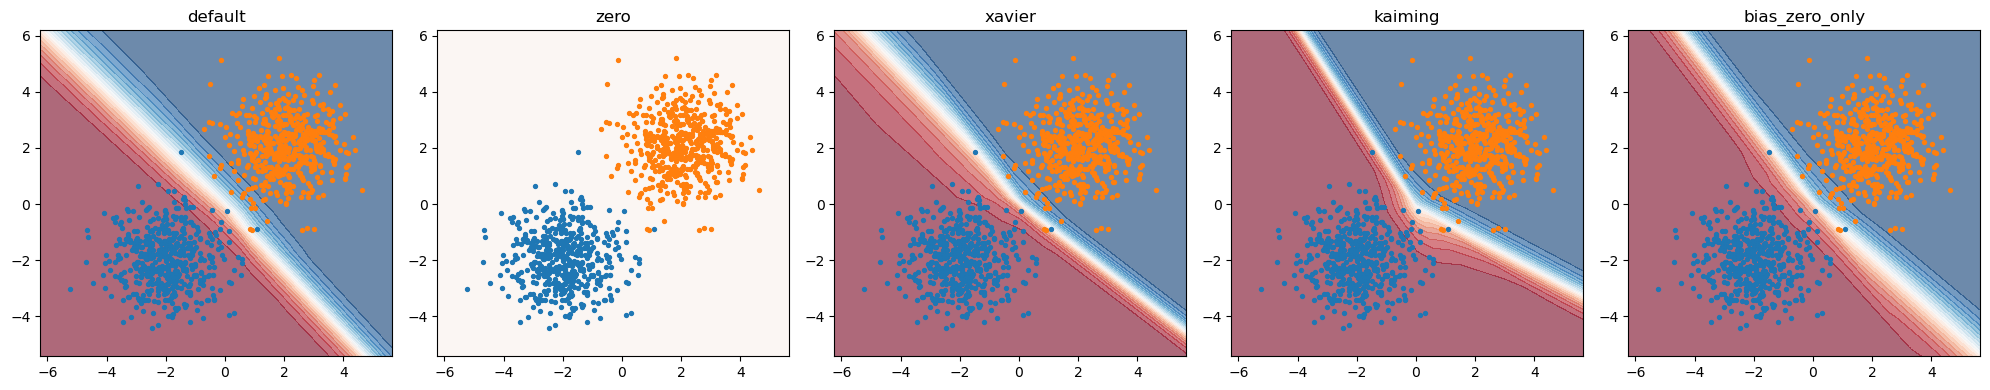

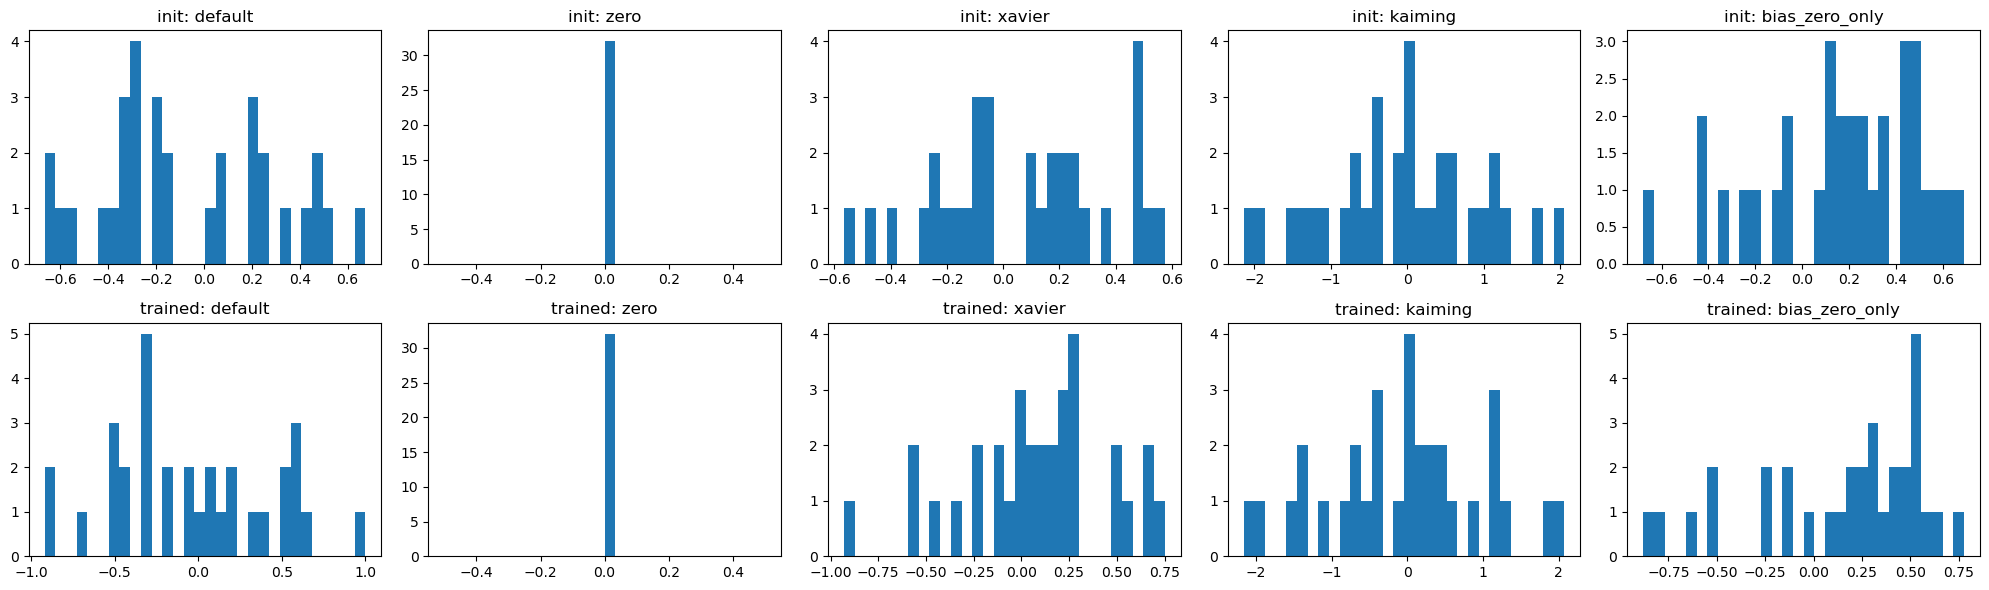


Summary:
default         -> final acc: 99.80% final loss: 0.0106
zero            -> final acc: 50.00% final loss: 0.6931
xavier          -> final acc: 99.80% final loss: 0.0091
kaiming         -> final acc: 99.80% final loss: 0.0084
bias_zero_only  -> final acc: 99.70% final loss: 0.0099

Notes:
- Zero init prevents symmetry breaking; network typically cannot learn and remains ~50% on balanced binary tasks.
- Xavier/Kaiming and default init break symmetry and allow learning; biases can safely be initialized to zero in most cases.


In [3]:
"""
Simple demo: 3-layer MLP (three Linear layers). Compare default initialization vs explicit zero initialization.
The notebook trains both models on a small synthetic binary classification task and plots losses and prints final accuracy.

Notes:
- Zero-initialized weights disable symmetry breaking between neurons; this usually prevents the network from learning useful diverse features and leads to poor performance.
- This demo trains both models with the same optimizer and hyperparameters so differences come from initialization.
"""

# Minimal imports
import torch
import torch.nn as nn
import torch.optim as optim
import numpy as np
import matplotlib.pyplot as plt

# reproducibility
seed = 42
np.random.seed(seed)
torch.manual_seed(seed)

# Synthetic dataset: two Gaussian clusters in 2D
N = 1000
xs0 = np.random.randn(N//2, 2) + np.array([-2.0, -2.0])
xs1 = np.random.randn(N//2, 2) + np.array([2.0, 2.0])
X = np.vstack([xs0, xs1]).astype(np.float32)
y = np.hstack([np.zeros(N//2), np.ones(N//2)]).astype(np.float32).reshape(-1, 1)

# Shuffle
perm = np.random.permutation(N)
X = X[perm]
y = y[perm]

# Convert to tensors
X_t = torch.from_numpy(X)
y_t = torch.from_numpy(y)

# Simple 3-layer MLP: (Linear -> ReLU -> Linear -> ReLU -> Linear) = 3 linear layers
class MLP(nn.Module):
    def __init__(self, input_dim=2, h1=16, h2=8):
        super().__init__()
        self.net = nn.Sequential(
            nn.Linear(input_dim, h1),
            nn.ReLU(),
            nn.Linear(h1, h2),
            nn.ReLU(),
            nn.Linear(h2, 1)
        )
    def forward(self, x):
        return self.net(x)

# Helper to set all linear layers' weights and biases to zero
def init_zero(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.constant_(m.weight, 0.0)
            if m.bias is not None:
                nn.init.constant_(m.bias, 0.0)

# Training loop (full-batch for simplicity)
def train_model(model, X, y, lr=0.1, epochs=300, verbose=False):
    opt = optim.SGD(model.parameters(), lr=lr)
    crit = nn.BCEWithLogitsLoss()
    losses = []
    accs = []
    for ep in range(epochs):
        model.train()
        logits = model(X)
        loss = crit(logits, y)
        opt.zero_grad()
        loss.backward()
        opt.step()
        losses.append(loss.item())
        with torch.no_grad():
            preds = (torch.sigmoid(logits) > 0.5).float()
            acc = (preds == y).float().mean().item()
            accs.append(acc)
        if verbose and (ep % 100 == 0):
            print(f"Epoch {ep}: loss={loss.item():.4f} acc={acc:.4f}")
    return losses, accs

# Build both models (original demo)
model_default = MLP()
model_zero = MLP()
init_zero(model_zero)

# Quick sanity: show initial weight norms
def weight_norms(model):
    total = 0.0
    for p in model.parameters():
        total += p.norm().item()
    return total

print(f"Initial weight norm (default): {weight_norms(model_default):.6f}")
print(f"Initial weight norm (zero):    {weight_norms(model_zero):.6f}")

# Train both (original demo)
epochs = 300
loss_default, acc_default = train_model(model_default, X_t, y_t, lr=0.1, epochs=epochs)
loss_zero, acc_zero = train_model(model_zero, X_t, y_t, lr=0.1, epochs=epochs)

# Print final accuracies
print(f"Final accuracy (default init): {acc_default[-1]*100:.2f}%")
print(f"Final accuracy (zero init):    {acc_zero[-1]*100:.2f}%")

# Plot losses and accuracy curves
plt.figure(figsize=(10,4))
plt.subplot(1,2,1)
plt.plot(loss_default, label='default init')
plt.plot(loss_zero, label='zero init')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()

plt.subplot(1,2,2)
plt.plot(acc_default, label='default init')
plt.plot(acc_zero, label='zero init')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training Accuracy')
plt.legend()
plt.tight_layout()
plt.show()

# Also show a few final weights for inspection
print('\nSample final weight slices (first Linear weight matrix):')
print('default:', model_default.net[0].weight.data[:2])
print('zero   :', model_zero.net[0].weight.data[:2])


# -----------------------------
# Additional experiments: compare several initializations
# -----------------------------

print('\n=== Additional experiments: compare initializations ===')

# Define inits
def init_xavier(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.xavier_uniform_(m.weight)
            if m.bias is not None:
                nn.init.zeros_(m.bias)

def init_kaiming(model):
    for m in model.modules():
        if isinstance(m, nn.Linear):
            nn.init.kaiming_normal_(m.weight, nonlinearity='relu')
            if m.bias is not None:
                nn.init.zeros_(m.bias)

# Build models for each init strategy
inits = {
    'default': lambda m: None,  # PyTorch default
    'zero': init_zero,
    'xavier': init_xavier,
    'kaiming': init_kaiming,
    'bias_zero_only': lambda m: [ (nn.init.constant_(p,0.0) if p.ndim==1 else None) for p in m.parameters() if p.ndim==1 ]
}

results = {}
initial_weight_hist = {}
trained_weight_hist = {}

for name, init_fn in inits.items():
    m = MLP()
    # for 'default' do nothing; for bias_zero_only handle differently
    if name == 'bias_zero_only':
        # zero biases, leave weights as default
        for p in m.parameters():
            if p.ndim == 1:
                nn.init.constant_(p, 0.0)
    else:
        init_fn(m)
    # record initial first-layer weight histogram
    w0 = m.net[0].weight.data.cpu().numpy().flatten().copy()
    initial_weight_hist[name] = w0
    # train
    l, a = train_model(m, X_t, y_t, lr=0.1, epochs=200)
    results[name] = (l, a, m)
    # record trained first-layer weight histogram
    trained_weight_hist[name] = m.net[0].weight.data.cpu().numpy().flatten().copy()
    print(f"{name:15} final acc: {a[-1]*100:.2f}% loss: {l[-1]:.4f}")

# Plot losses for experiments
plt.figure(figsize=(12,5))
plt.subplot(1,2,1)
for name in results.keys():
    plt.plot(results[name][0], label=name)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss by initialization')
plt.legend()

plt.subplot(1,2,2)
for name in results.keys():
    plt.plot(results[name][1], label=name)
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Accuracy by initialization')
plt.legend()
plt.tight_layout()
plt.show()

# Decision boundary plot helper
import itertools

def plot_decision_boundary(model, ax, title=None):
    # mesh grid
    xx, yy = np.meshgrid(np.linspace(X[:,0].min()-1, X[:,0].max()+1, 200),
                         np.linspace(X[:,1].min()-1, X[:,1].max()+1, 200))
    grid = np.stack([xx.ravel(), yy.ravel()], axis=1).astype(np.float32)
    with torch.no_grad():
        logits = model(torch.from_numpy(grid))
        probs = torch.sigmoid(logits).cpu().numpy().reshape(xx.shape)
    cs = ax.contourf(xx, yy, probs, levels=20, cmap='RdBu', alpha=0.6)
    ax.scatter(X[y.ravel()==0,0], X[y.ravel()==0,1], s=8, label='class 0')
    ax.scatter(X[y.ravel()==1,0], X[y.ravel()==1,1], s=8, label='class 1')
    ax.set_title(title)
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())

# Plot decision boundaries for a subset (default, zero, xavier, kaiming, bias_zero_only)
fig, axs = plt.subplots(1,5, figsize=(20,4))
for ax, name in zip(axs.ravel(), list(results.keys())):
    plot_decision_boundary(results[name][2], ax, title=name)
plt.tight_layout()
plt.show()

# Plot weight histograms before and after for first-layer
fig, axs = plt.subplots(2, len(initial_weight_hist), figsize=(4*len(initial_weight_hist), 6))
for i, name in enumerate(initial_weight_hist.keys()):
    axs[0,i].hist(initial_weight_hist[name], bins=30)
    axs[0,i].set_title(f"init: {name}")
    axs[1,i].hist(trained_weight_hist[name], bins=30)
    axs[1,i].set_title(f"trained: {name}")
plt.tight_layout()
plt.show()

# Short summary printed
print('\nSummary:')
for name in results.keys():
    l, a, m = results[name]
    print(f"{name:15} -> final acc: {a[-1]*100:.2f}% final loss: {l[-1]:.4f}")

print('\nNotes:')
print('- Zero init prevents symmetry breaking; network typically cannot learn and remains ~50% on balanced binary tasks.')
print('- Xavier/Kaiming and default init break symmetry and allow learning; biases can safely be initialized to zero in most cases.')
